In [38]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence
import numpy as np
import datetime
import random

from sklearn.metrics import confusion_matrix,accuracy_score
import matplotlib.pyplot as plt

In [2]:
batch_size=256
epochs=500
seed=1
cuda=torch.cuda.is_available()
log_interval=1
r_dim=256
z_dim=256
result_path="results_np_class/"
file_name=result_path+"loss"


device = torch.device("cuda" if cuda else "cpu") #

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
TrainData=datasets.MNIST('data', train=True, download=False,
                   transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(
    TrainData,
    batch_size=batch_size, shuffle=True, **kwargs)
TestData=datasets.MNIST('data', train=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(
    TestData,
    batch_size=batch_size, shuffle=True, **kwargs)

In [3]:
class NP(nn.Module):
    def __init__(self, r_dim,z_dim):
        super(NP, self).__init__()
        self.r_dim = r_dim
        self.z_dim = z_dim
    
        self.h_1 = nn.Linear(784+1, 400)
        self.h_2 = nn.Linear(400, 400)
        self.h_3 = nn.Linear(400, self.r_dim)

        self.r_to_z_mean = nn.Linear(self.r_dim, self.z_dim)
        self.r_to_z_logvar = nn.Linear(self.r_dim, self.z_dim)

        self.g_1 = nn.Linear(self.z_dim + 784, 400)
        self.g_2 = nn.Linear(400, 400)
        self.g_3 = nn.Linear(400, 400)
        self.g_4 = nn.Linear(400, 400)
        self.g_y_proba = nn.Linear(400, 1)
        self.g_y_var = nn.Linear(400, 1)
        

    def h(self, x_y):
        x_y = F.relu(self.h_1(x_y))
        x_y = F.relu(self.h_2(x_y))
        x_y = F.relu(self.h_3(x_y))
        return x_y

    def aggregate(self, r):
        return torch.mean(r, dim=0)

    def g(self,z_sample, x_target):
        z_et_x = torch.cat([z_sample, x_target], dim=1)
        input = F.relu(self.g_1(z_et_x))
        input = F.relu(self.g_2(input))
        input = F.relu(self.g_3(input))
        input = F.relu(self.g_4(input))
        y_mu=F.sigmoid(self.g_y_proba(input))*10
        y_sigma=sigma = 0.1 + 0.9 * F.softplus(self.g_y_var(input))
        return y_mu,y_sigma
    
    
    def xy_to_z_params(self, x, y):
        x_y = torch.cat([x, y], dim=1)
        r_i = self.h(x_y)
        r = self.aggregate(r_i)
        mu = self.r_to_z_mean(r)
        logvar = self.r_to_z_logvar(r)
        sigma=0.1+0.9*torch.sigmoid(logvar)
        return mu, sigma

    def forward(self, x_context, y_context, x_all=None, y_all=None):
        
        #produire z
        z_context_mu,z_context_sigma = self.xy_to_z_params(x_context, y_context)  # (mu, logvar) of z
        q_context = Normal(z_context_mu, z_context_sigma)
        
        if self.training:  # loss function will try to keep z_context close to z_all     
            
            z_target_mu,z_target_sigma = self.xy_to_z_params(x_context, y_context)
            q_target = Normal(z_target_mu, z_target_sigma) 
            z_sample = q_target.rsample()
            z_sample = z_sample.expand(x_all.size()[0],self.z_dim)
            # Get parameters of output distribution
            y_pred_mu, y_pred_sigma = self.g(z_sample,x_all)
            #print(y_pred_mu.size())
            p_y_pred = Normal(y_pred_mu, y_pred_sigma)

            return p_y_pred, q_target, q_context
        else:  # at test time we don't have the image so we use only the context
            z_sample = q_context.rsample()
            z_sample = z_sample.expand(x_all.size()[0],self.z_dim)
            # Predict target points based on context
            y_pred_mu, y_pred_sigma = self.g(z_sample,x_all)
            p_y_pred = Normal(y_pred_mu, y_pred_sigma)
            return p_y_pred,q_context,q_context

def np_loss(p_y_pred, y_target, q_target, q_context):
    #return logprob + KLD
    log_likelihood = p_y_pred.log_prob(y_target.float())
    
    log_likelihood=log_likelihood.sum()#.mean(dim=0)
    # KL has shape (batch_size, r_dim). Take mean over batch and sum over
    # r_dim (since r_dim is dimension of normal distribution)
    kl = kl_divergence(q_target, q_context).sum()

    return -log_likelihood + kl
    

In [4]:
model=NP(r_dim,z_dim)
model.load_state_dict(torch.load(result_path+"model_200.pt"))
model.eval()

NP(
  (h_1): Linear(in_features=785, out_features=400, bias=True)
  (h_2): Linear(in_features=400, out_features=400, bias=True)
  (h_3): Linear(in_features=400, out_features=256, bias=True)
  (r_to_z_mean): Linear(in_features=256, out_features=256, bias=True)
  (r_to_z_logvar): Linear(in_features=256, out_features=256, bias=True)
  (g_1): Linear(in_features=1040, out_features=400, bias=True)
  (g_2): Linear(in_features=400, out_features=400, bias=True)
  (g_3): Linear(in_features=400, out_features=400, bias=True)
  (g_4): Linear(in_features=400, out_features=400, bias=True)
  (g_y_proba): Linear(in_features=400, out_features=1, bias=True)
  (g_y_var): Linear(in_features=400, out_features=1, bias=True)
)

In [ ]:
def train(epoch,learning_rate=1e-3):
    model.train()
    train_loss = 0
    optimizer = optim.Adam(model.parameters(), lr=learning_rate/epoch)
    for batch_idx, (x_all, y_all) in enumerate(train_loader):
        x_all=x_all.to(device)
        y_all=y_all.to(device).view(-1,1).float()
        batch_size = y_all.shape[0]
        x_all=x_all.view(batch_size,-1)
        N = random.randint(1, batch_size)  # number of context points
        x_context = x_all[:N,:]
        y_context = y_all[:N,:]
        optimizer.zero_grad()
        p_y_pred, q_target, q_context = model(x_context, y_context, x_all, y_all)
        loss = np_loss(p_y_pred, y_all, q_target, q_context)
        loss.backward()   
        train_loss += loss.item()    
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\n'.format(
                epoch, batch_idx * len(y_all), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader),
                       loss.item() / len(y_all)))
    print('====> Epoch: {} Average loss: {:.4f}\n'.format(
        epoch, train_loss / len(train_loader.dataset)))
    return train_loss / len(train_loader.dataset)

In [ ]:
num_epoch=200
for i in range(1,num_epoch):
    train(i)
torch.save(model.state_dict(), result_path+"model_{}_{}.pt".format(num_epoch,datetime.datetime.now()))

In [5]:
X_train_list=[]
y_train_list=[]
for X,y in TrainData:
    X_train_list.append(X.view(-1,784))
    y_train_list.append(y.view(1,1).float())
X_train=torch.cat(X_train_list)
y_train=torch.cat(y_train_list)

In [6]:
X_test_list=[]
y_test_list=[]
for X,y in TestData:
    X_test_list.append(X.view(-1,784))
    y_test_list.append(y.view(1,1).float())
X_test=torch.cat(X_test_list)
y_test=torch.cat(y_test_list)

In [7]:
p,_,__=model(X_train,y_train,X_test)
pred=torch.round(p.mean)

/home/h86479/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [8]:
confusion_matrix(pred.long().numpy(),y_test.long().numpy())

array([[ 963,    0,    3,    0,    0,    3,    1,    0,    0,    1],
       [   6, 1119,    4,    0,    0,    0,    3,    1,    1,    4],
       [   1,    8,  986,    4,    2,    0,    3,    9,    3,    0],
       [   1,    3,   15,  966,    4,    5,    1,    6,    3,    7],
       [   1,    2,   12,   12,  950,   10,    4,    6,    7,    5],
       [   3,    1,    5,    9,    4,  858,   16,    7,    6,    6],
       [   4,    1,    3,    8,    6,   11,  927,   12,   11,    7],
       [   0,    0,    3,    8,    4,    4,    1,  977,   24,   10],
       [   1,    1,    0,    3,    9,    1,    2,    4,  915,   28],
       [   0,    0,    1,    0,    3,    0,    0,    6,    4,  941]])

In [9]:
accuracy_score(pred.long().numpy(),y_test.long().numpy())

0.9602

In [48]:
for i in range(len(X_test)):
    
    p,_,__=model(X_train,y_train,X_test[i].unsqueeze(0))
    pred=F.softmax(p.log_prob(torch.tensor([0,1,2,3,4,5,6,7,8,9]).float())).argmax()
    if pred!=y_test[i].long():
        print(i)
        print("class:",y_test[i].long().item(),",predi:",pred.item(),",mean:",p.mean.item(),",var:",p.variance.item())
        

/home/h86479/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/h86479/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


33
class: 4 ,predi: 3 ,mean: 3.2986350059509277 ,var: 0.013213139958679676
149
class: 2 ,predi: 4 ,mean: 4.127389430999756 ,var: 1.6065056324005127
151
class: 9 ,predi: 8 ,mean: 8.017189979553223 ,var: 0.6876488924026489
233
class: 8 ,predi: 6 ,mean: 5.799896717071533 ,var: 12.870138168334961
241
class: 9 ,predi: 8 ,mean: 8.104353904724121 ,var: 0.25801169872283936
247
class: 4 ,predi: 3 ,mean: 2.5488433837890625 ,var: 0.028072532266378403
259
class: 6 ,predi: 2 ,mean: 2.0696728229522705 ,var: 24.394588470458984
321
class: 2 ,predi: 7 ,mean: 7.021798610687256 ,var: 0.01315377838909626
340
class: 5 ,predi: 4 ,mean: 3.681771755218506 ,var: 0.15346980094909668
359
class: 9 ,predi: 8 ,mean: 8.150801658630371 ,var: 0.9888001084327698
381
class: 3 ,predi: 6 ,mean: 5.771666526794434 ,var: 3.993598699569702
445
class: 6 ,predi: 0 ,mean: 0.06233462691307068 ,var: 0.010551170445978642
447
class: 4 ,predi: 8 ,mean: 7.808404445648193 ,var: 1.8129602670669556
448
class: 9 ,predi: 8 ,mean: 8.2067317

KeyboardInterrupt: 

/home/h86479/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([[2.5126]], grad_fn=<MulBackward0>)
tensor([[4.3929]], grad_fn=<PowBackward0>)


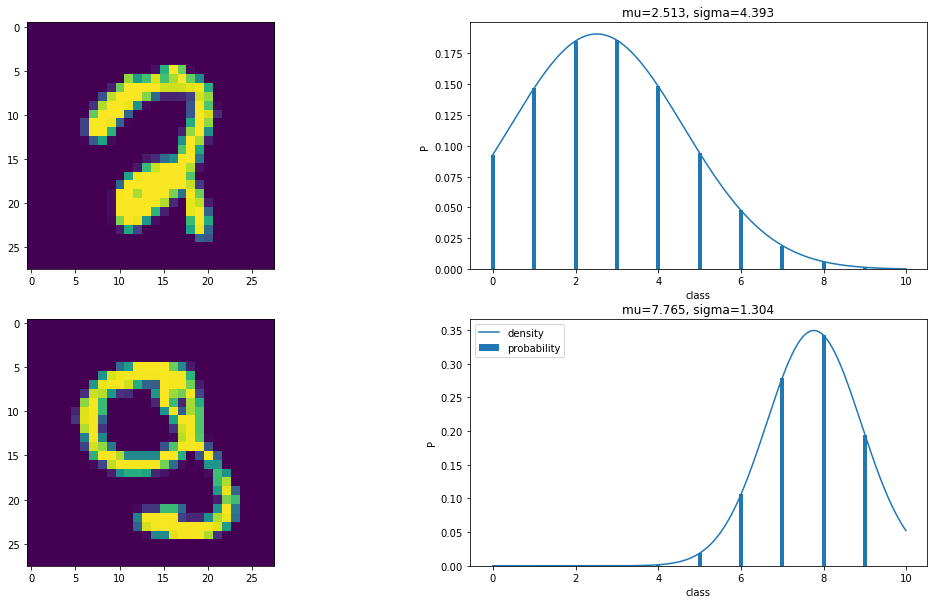

In [59]:
test_index=119
p,_,__=model(X_train,y_train,X_test[test_index].unsqueeze(0))
print(p.mean)
print(p.variance)
#Plot distribution and probability for false cases
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')
plt.rcParams['figure.figsize'] = (18.0, 10.0)
fig=plt.figure()
fig.add_subplot(2, 2, 1)
plt.imshow(X_test[test_index].squeeze().view(28,28).numpy())
fig.add_subplot(2, 2, 2)
plt.bar(np.arange(0,10),torch.exp(p.log_prob(torch.tensor([0,1,2,3,4,5,6,7,8,9]).float())).view(-1).detach().numpy(),width=0.1,label="probability")
plt.plot(np.arange(0,10,0.01),torch.exp(p.log_prob(torch.tensor(np.arange(0,10,0.01)).float())).view(-1).detach().numpy(),label="density")
plt.xlabel("class")
plt.ylabel("P")
plt.title("mu={:.3f}, sigma={:.3f}".format(p.mean.item(),p.variance.item()))

test_index=151
p,_,__=model(X_train,y_train,X_test[test_index].unsqueeze(0))
fig.add_subplot(2, 2, 3)
plt.imshow(X_test[test_index].squeeze().view(28,28).numpy())
fig.add_subplot(2, 2, 4)
plt.bar(np.arange(0,10),torch.exp(p.log_prob(torch.tensor([0,1,2,3,4,5,6,7,8,9]).float())).view(-1).detach().numpy(),width=0.1,label="probability")
plt.plot(np.arange(0,10,0.01),torch.exp(p.log_prob(torch.tensor(np.arange(0,10,0.01)).float())).view(-1).detach().numpy(),label="density")
plt.xlabel("class")
plt.ylabel("P")
plt.title("mu={:.3f}, sigma={:.3f}".format(p.mean.item(),p.variance.item()))
plt.legend()
plt.savefig("npc_res.pdf")


In [95]:
test_index=119
p,_,__=model(X_train,y_train,X_test[test_index].unsqueeze(0))
print(p.mean)
print(p.variance)

tensor([[2.5377]], grad_fn=<MulBackward0>)
tensor([[4.6945]], grad_fn=<PowBackward0>)
